Each row of the file represents a white card that was given to a player in a round and how it performed. It also contains information about the round like how long it took and what black card was dealt.
So columns that describe general round data will be exactly the same for all ten rows of that round. These rows are: fake_round_id, round_completion_seconds, round_skipped, black_card_text, and black_card_pick_num.
But columns that describe a property of the white card will change over the ten rows of that round. These rows are: white_card_text, won, and winning_index.


The columns:
* fake_round_id: a unique integer for every round. This is to help you separate one round from another to find which 10 cards were presented in every round.
* round_completion_seconds: the number of seconds it took for the user to pick a winner after being presented the cards for that round. You'll probably want to filter out users that decide too quickly by setting some minimum threshold for this. Some of these numbers can be insanely high as well since the user just left their browser open for hours or possibly days before picking a winner.
* round_skipped: we have a red button in the top right of the lab page that says "No Good Plays!". If a user clicks this button, round_skipped will be "True" and no white card will be marked as a winner.
* black_card_text: self explanatory.
* black_card_pick_num: The number of white cards that the black card requires. Generally 1, but will be 2 for black cards like "That's right, I killed _____. How, you ask? _____."
* white_card_text: self explanatory.
* won: True if this white card won the round.
* winning_index: This is for storing the order that the winning card(s) were picked in. If the white card didn't win, this will just contain a null value (NULL). If the card won and the black card was a normal "Pick 1" this will always be 0. But if the black card was a "Pick 2", one of the winners will be 0 and the other will be 1. This is how you figure out which blank in pick 2 black cards was meant to be filled by which winning white card. The first blank is filled by the 0 and the second one by the 1.

* sample groups (for test);
* https://hippocampus-garden.com/pandas_group_sample/
```
sampled_users = np.random.choice(df["user_id"].unique(), 100)
df_sampled = df.groupby('user_id').filter(lambda x: x["user_id"].values[0] in sampled_users)
df_sampled["user_id"].nunique()
```

In [76]:
import pandas as pd
import seaborn as sns
pd.set_option("display.precision", 4)
pd.set_option('display.width', 1024)
pd.set_option('display.max_colwidth', None)
%matplotlib inline 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_auc_score  
# https://stackoverflow.com/questions/53784971/how-to-disable-convergencewarning-using-sklearn
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

from sentence_transformers import SentenceTransformer, util
LOAD_CSV = False ## load raw data from csv instead of parquet (which has had some cols dropped)

MIN_PAIR_FREQ = 4
SAVE_TRAIN_DATA = False

LOWERCASE_DATA = False
DROP_DOUBLES = True ## drop white cards with pick 2 options ; and their blacks. (TODO: analyze interesting pairs)
DROP_SKIPPED = True ## ignore rounds where skipped

In [2]:
# !pip install pyarrow
# !conda install -c conda-forge category_encoders -y
from category_encoders.wrapper import NestedCVWrapper ## cv
from category_encoders import TargetEncoder,WOEEncoder,CountEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.cat_boost import CatBoostEncoder
# cat_encoder = TargetEncoder(min_samples_leaf=3, smoothing=0.2)
## note - not split by groups
cat_encoder = NestedCVWrapper(feature_encoder=CatBoostEncoder(), cv=5)#CatBoostEncoder()

Load data

* Note there are some near-duplicate cards (e.g. footballers - could minhash - https://github.com/chrisjmccormick/MinHash/blob/master/runMinHashExample.py , LSH/shingles : https://onestopdataanalysis.com/lsh/  (broken library?) , https://github.com/zyocum/dedup/blob/master/dedup.py ,

`Datasketch` https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/ ,
https://stackoverflow.com/questions/25114338/approximate-string-matching-using-lsh , 

SKLearn friendly?: http://ethen8181.github.io/machine-learning/recsys/content_based/lsh_text.html

`dedupe` library - https://github.com/dedupeio/dedupe

* Paraphrase mining using sentence bert - https://www.sbert.net/examples/applications/paraphrase-mining/README.html  (may be too semantic)

* Example: "10 football players with erections *barreling* towards you at full speed" - 10 football players with erections **barrelling** towards you at full speed."

Task modelling:
* Ranking = most accurate
* Regression/classification: can be done just over single cards, or between pairs. 
    * if pairs-wise: can use sentencebert/SNLI models (which assume pairs of sentences) - https://github.com/UKPLab/sentence-transformers
    
    
Examples:

* https://www.sbert.net/examples/training/sts/README.html#training-data
* https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli.py
* https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli_v2.py


* Keras example (not sentenceBert): https://keras.io/examples/nlp/semantic_similarity_with_bert/


* Interpretability tool : https://github.com/cdpierse/transformers-interpret

In [3]:
%%time
#### Original processing of data, before I saved it as a parquet for faster subsequent loading: 
if LOAD_CSV:
    df = pd.read_csv(DATA)
    ## remove punct/newlines
    df["white_card_text"] = df["white_card_text"].replace("\n", " ",regex=True).replace("\t", " ",regex=True) # .replace("\r", "")
    df["black_card_text"] = df["black_card_text"].replace("\n", " ",regex=True).replace("\t", " ",regex=True) # .replace("\r", "")

    ## add number within group - may not actually be the read order shown on screen!! 
    df['ID_index'] = df.groupby('fake_round_id').cumcount() + 1

    print(df[['black_card_text', 'black_card_pick_num', 'white_card_text',"fake_round_id"]].nunique())
    print(df.describe())
    
    ## save to disk in compressed, binary format
    df.drop(["winning_index"],axis=1).to_parquet('cah_lab_data.parquet')
#     df.drop(["winning_index"],axis=1).to_feather('cah_lab_data.feather')
    
else:  # load data saved in above code previously
    df = pd.read_parquet('cah_lab_data.parquet')
#     df= pd.read_feather('cah_lab_data.feather')

if DROP_SKIPPED:
    df = df.loc[~df["round_skipped"]]
df

Wall time: 723 ms


,fake_round_id,round_completion_seconds,round_skipped,black_card_text,black_card_pick_num,white_card_text,won,ID_index
0,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,Going inside at some point because of the mosquitoes.,False,1
1,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,Being fat from noodles.,False,2
2,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,Letting this loser eat me out.,False,3
3,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,That chicken from Popeyes.®,False,4
4,1,24,False,"Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",1,A sorry excuse for a father.,False,5
...,...,...,...,...,...,...,...,...
2989545,298955,7613,False,Oh my god! _____ killed Kenny!,1,Breastfeeding a ten-year-old.,False,6
2989546,298955,7613,False,Oh my god! _____ killed Kenny!,1,Happy daddies with happy sandals.,False,7
2989547,298955,7613,False,Oh my god! _____ killed Kenny!,1,Jerking off to a 10-second RealMedia clip.,False,8
2989548,298955,7613,False,Oh my god! _____ killed Kenny!,1,Getting naked and watching Nickelodeon.,False,9


In [4]:
# ### could use the winning_index==1 cases instead to filter these (but then misses skipped rounds)
# # df["double_card"] = df["black_card_text"].str.count("_____")>1 
# df["double_card"] = df["black_card_pick_num"]>1
# print(df["double_card"].describe())
# df.loc[df["double_card"]].drop_duplicates("black_card_text")


##### analyze rounds skipped
* at level of round -  5% of rounds skipped due to all combinations being considered "unfunny"

In [5]:
df.drop_duplicates("fake_round_id")["round_skipped"].mean()

0.058145874797210284

In [6]:
# # df.loc[~df["winning_index"].isna()]
# df.loc[df["winning_index"]>=1][["black_card_text"]].drop_duplicates() ## these are all double cards

In [7]:
if LOWERCASE_DATA:
    df["white_card_text"] = df["white_card_text"].str.lower()
    df["black_card_text"] = df["black_card_text"].str.lower()

##### Fit prior odds / encoder
* Use targetEncoder or WOE
* Do IPW either here, or later on data subset? 

In [8]:
## for now, fit on just white cards, instead of black, white  (For black, we could just use mean_skipped as prior and multiply)
df["prior_white"] = cat_encoder.fit_transform(X=df["white_card_text"],y=df["won"])

# df["prior_white"] = cat_encoder.transform(df["white_card_text"]) ## catboost encoder - doesn't have min 0 (for those with 0 cases)
df.drop_duplicates(["white_card_text"])["prior_white"].describe(percentiles=[])

count    2128.0000
mean        0.1061
std         0.0528
min         0.0037
50%         0.0958
max         0.3959
Name: prior_white, dtype: float64

### check white prior as baseline model

* 19% win rate

In [9]:
df.sort_values(["prior_white"],ascending=False).groupby("fake_round_id")["won"].head(1).mean()##19%

0.21408907695138063

In [10]:
# df.sort_values(["prior_white"],ascending=False).groupby("fake_round_id")[["won","prior_white"]].head(1).corr()
## 0.06 correlation

# df[["won","prior_white"]].corr() ## in overall data: 0.16 corr

### IPW weighting
 - Unsure which method is correct, I try my own-ish, based on the first ipw definiton
```Def ipw (y_true, y_pred):
	"""
	inverse probability weighting, for binary target.
	The weight is 1/P for treated units and 1/(1-P) for untreated units.
	"""
	If y_true:
		Return 1/y_pred
	Else:
Return 1/(1-y_pred)
```
```
## ALT, faster code for a variable:
## https://gist.github.com/BioSciEconomist/826556977841cbf966f03542b2be0c55#file-iptw-demo-py-L85
# calculate propensity score weights for ATT (Austin, 2011)	
	df['ipw_wt'] = np.where(df['treat']==1, 1,df.ps/(1-df.ps))
```
https://radiant-brushlands-42789.herokuapp.com/medium.com/swlh/demystifying-the-inverse-probability-weighting-method-b5056ba3a72d
IPW can be implemented in two steps:
1) Estimates a logit mode to estimate the probability (labelled as P) of being treated.
2), one uses the Weighted Least Squares (WLS) to estimate the effect of W on Y. The weight is the inverse of the estimated probability. Specifically, the weight is 1/P for treated units and 1/(1-P) for untreated units.
https://towardsdatascience.com/using-machine-learning-metrics-to-evaluate-causal-inference-models-d066f1bb2b7a

## White ("Answer") Cards

In [11]:
df["white_card_text"].drop_duplicates().str.split().str.len().describe()

count    2128.0000
mean        4.9619
std         3.2156
min         1.0000
25%         2.0000
50%         4.0000
75%         7.0000
max        23.0000
Name: white_card_text, dtype: float64

In [12]:
df.groupby(by="white_card_text").agg(picks=("won","sum"), pick_opportunities=("won","count"),
                                                pick_ratio=("won","mean"))

,picks,pick_opportunities,pick_ratio
white_card_text,,,
...it is unclear.,97,1576,0.0615
10 Incredible Facts About the Anus.,156,1512,0.1032
10 football players with erections barreling towards you at full speed.,4,34,0.1176
10 football players with erections barrelling towards you at full speed.,207,1465,0.1413
"10,000 Syrian refugees.",204,1531,0.1332
...,...,...,...
Your mouth.,174,1600,0.1087
Your weird brother.,191,1552,0.1231
Yummy yummy yummy yummy rat pussy.,261,1548,0.1686


In [13]:
print("white cards against humanity - aggregated funniest")
df_white = df.groupby(by="white_card_text").agg(picks=("won","sum"), pick_opportunities=("won","count"),
                                                pick_ratio=("won","mean"),round_skip_ratio=("round_skipped","mean")).sort_values("pick_ratio",ascending=False)

print(df_white.describe())
df_white.head(20)

white cards against humanity - aggregated funniest
           picks  pick_opportunities  pick_ratio  round_skip_ratio
count  2128.0000           2128.0000   2128.0000         2128.0000
mean    149.6748           1404.8637      0.1065            0.0589
std      87.0771            408.7169      0.0525            0.0135
min       0.0000             19.0000      0.0000            0.0000
25%      91.7500           1490.0000      0.0673            0.0537
50%     139.0000           1522.0000      0.0958            0.0580
75%     203.0000           1552.0000      0.1384            0.0627
max     459.0000           3006.0000      0.3571            0.1923


,picks,pick_opportunities,pick_ratio,round_skip_ratio
white_card_text,,,,
Syphilis.,10,28,0.3571,0.0357
Anal.,459,1572,0.2920,0.0337
"Sluts, whores, and bitches.",456,1598,0.2854,0.0538
Tentacle porn.,434,1525,0.2846,0.0656
Incest.,435,1530,0.2843,0.0471
A big black dick.,425,1500,0.2833,0.0513
Cock.,429,1524,0.2815,0.0413
The death penalty.,10,36,0.2778,0.0000
Gay thoughts.,418,1523,0.2745,0.0571


11 0 picks
32 0-1
106 2-5 picks
          picks  pick_opportunities  pick_ratio  round_skip_ratio
count  2128.000            2128.000    2128.000          2128.000
mean    149.675            1404.864       0.106             0.059
std      87.077             408.717       0.053             0.013
min       0.000              19.000       0.000             0.000
25%      91.750            1490.000       0.067             0.054
50%     139.000            1522.000       0.096             0.058
75%     203.000            1552.000       0.138             0.063
max     459.000            3006.000       0.357             0.192


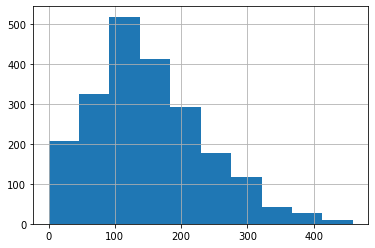

In [14]:
print(df_white.loc[df_white["picks"]==0].shape[0], "0 picks")
print(df_white.loc[df_white["picks"]<2].shape[0], "0-1")
print(df_white.loc[df_white["picks"].between(2,5)].shape[0], "2-5 picks")

print(df_white.describe().round(3))

df_white["picks"].hist();

Just using global "picks" as a feature is a leak, and will have 100% precision for a few of the cards that were never picked.
* We could correct this better, using a proper encoder, e.g. target encoding + nested CV : https://contrib.scikit-learn.org/category_encoders/targetencoder.html
    * https://brendanhasz.github.io/2019/03/04/target-encoding
    * https://contrib.scikit-learn.org/category_encoders/woe.html

## Black ("Question") Cards

In [15]:
print("BLACK cards against humanity - aggregated funniest")
## pick doesn't necessarily make sense here
df_black = df.groupby(by="black_card_text").agg(picks=("won","sum"), pick_opportunities=("won","count"),
                                                pick_ratio=("won","mean"),round_skip_ratio=("round_skipped","mean"))
df_black.sort_values(["pick_ratio","round_skip_ratio"],ascending=False,inplace=True)

df_black

BLACK cards against humanity - aggregated funniest


,picks,pick_opportunities,pick_ratio,round_skip_ratio
black_card_text,,,,
Problem: _____. Solution: _____. (PICK 2),14,70,0.2000,0.0000
"You: _____. Me, an intellectual: _____. (PICK 2)",10,50,0.2000,0.0000
"In Jordan Peele's new thriller, a young family discovers that _____ had really been _____ all along.",206,1070,0.1925,0.0374
_____ is a slippery slope that leads to _____.,1300,6790,0.1915,0.0427
_____ would be woefully incomplete without _____.,1334,6970,0.1914,0.0430
...,...,...,...,...
"Instead of playing a card this round, everyone must stare at the Card Czar while making a sound you'd make after tasting something delicious.",462,6550,0.0705,0.2947
"I am so, so sorry everyone. I take full responsibility for _____.",2,30,0.0667,0.3333
"I hate to be that guy, but I just don't see the point of _____.",2,30,0.0667,0.3333


In [16]:
df_black.describe().round(2)

,picks,pick_opportunities,pick_ratio,round_skip_ratio
count,650.00,650.00,650.00,650.00
mean,490.01,4599.31,0.10,0.06
std,356.67,2850.48,0.03,0.05
min,1.00,10.00,0.06,0.00
25%,86.25,932.50,0.09,0.04
50%,592.00,6275.00,0.10,0.05
75%,624.00,6550.00,0.10,0.07
max,1392.00,7430.00,0.20,0.40


In [17]:
df["black_card_text"].drop_duplicates().str.split().str.len().describe()

count    650.0000
mean      11.2954
std        5.2317
min        2.0000
25%        7.0000
50%       11.0000
75%       14.0000
max       41.0000
Name: black_card_text, dtype: float64

In [18]:
# ### without pick 2 cards:  All variance in (black cards) pick_ratio is solely due to round skipping
# df.loc[(df["black_card_pick_num"]<2) & (~df["round_skipped"])].groupby(by="black_card_text").agg(picks=("won","sum"), pick_opportunities=("won","count"),
#                                                 pick_ratio=("won","mean"),round_skip_ratio=("round_skipped","mean")).describe()

### Filter data

* drop pick 2  cards
* Drop rounds where no card picked (ALT: could be alternate target)

In [19]:
if DROP_DOUBLES:
    df = df.loc[df["black_card_pick_num"]<2]

    
print(df.shape[0])
print(df.nunique())

2446360
fake_round_id               244636
round_completion_seconds      1665
round_skipped                    1
black_card_text                583
black_card_pick_num              1
white_card_text               2128
won                              2
ID_index                        10
prior_white                  11398
dtype: int64


## prior white baseline
* check Acc@1 if sorting by baseline/mean win level for whites

### round level sample dataset
* downsample + change class freq 


In [20]:
df_sample = df.sort_values("fake_round_id")

df_sample = df_sample.loc[df["black_card_pick_num"]<2]
df_sample = df_sample.loc[~df["round_skipped"]]

df_sample['ipw_wt'] = np.where(df_sample['won']>0, 1/df_sample["prior_white"],1/(1-df_sample["prior_white"]))

# df_sample = df_sample.iloc[0:300000]
df_sample = df_sample.tail(200000)
## filter groups without whole game
df_sample = df_sample[df_sample['fake_round_id'].groupby(df_sample['fake_round_id']).transform('size')==10]
print(df_sample.shape[0])
# print(df_sample.tail(11)["fake_round_id"])

## downsample data
df1 = df_sample.loc[df_sample["won"]==True]
df2 = df_sample.loc[df_sample["won"]==False].groupby("fake_round_id").sample(n=5).reset_index()
df_sample = pd.concat([df1,df2],ignore_index=True).sample(frac=1).drop_duplicates()
print(df_sample.shape)
df_sample.tail(11)

200000
(120000, 11)


,fake_round_id,round_completion_seconds,round_skipped,black_card_text,black_card_pick_num,white_card_text,won,ID_index,prior_white,ipw_wt,index
72201,287366,27,False,"My fellow Americans: Before this decade is out, we will have _____ on the moon!",1,Repression.,False,3,0.0816,1.0888,2873652.0
6872,282917,13,False,"Now in bookstores: ""The Audacity of _____,"" by Barack Obama.",1,Teaching a robot to love.,True,6,0.0623,16.0433,NaN
117609,298355,23,False,"Hey, kids. I'm Connor's dad, but you can call me Mr. _____.",1,A mopey zoo lion.,False,7,0.0429,1.0449,2983546.0
73554,287700,5,False,"This Friday at the Liquid Lounge, it's _____ Night! Ladies drink free.",1,The Hellman's Mayonnaise Corporation.,False,10,0.0757,1.0819,2876999.0
45688,280759,4,False,Military historians remember Alexander the Great for his brilliant use of _____ against the Persians.,1,"Two contrasting monologues--one classical, one contemporary.",False,10,0.0320,1.0330,2807589.0
97779,293482,7,False,"Dammit, Gary. You can't just solve every problem with _____.",1,Carrying my poop around in a ziplock bag.,False,2,0.0904,1.0994,2934811.0
91335,291950,12,False,"Goldfinger! He's the man, the man with _____.",1,"Trevor, the world's greatest boyfriend.",False,7,0.0602,1.0641,2919496.0
77848,288730,25,False,Click Here for _____!!!,1,Slender toes begging to be sucked.,False,2,0.0830,1.0906,2887291.0
95833,293024,19,False,"The fault, dear Brutus, is not in our stars, but in _____.",1,Getting Mommy another beer.,False,3,0.0751,1.0813,2930232.0
119135,298740,3,False,"The Five Stages of Grief: denial, anger, bargaining, _____, acceptance.",1,A man who is so cool that he rides on a motorcycle.,False,2,0.0388,1.0404,2987391.0


In [21]:
# df_sample[['fake_round_id', 'round_completion_seconds',  'black_card_text', 'white_card_text', 'won', 'ID_index', 'prior_white', 'ipw_wt']]\
# .to_csv("cah_rounds_180k_downsampled_v1.csv.gz",index=False,compression="gzip")

### Analyze pairs
* Note cases with few occurrences imbalance the data
* This is pairs that actually were shown to users (i.e #picks >= 1) 

In [22]:
print("Winning pair combinations - aggregated funniest")
df_pairs = df.groupby(by=["white_card_text","black_card_text"]).agg(picks=("won","sum"), pick_opportunities=("won","count"),
                                                pick_ratio=("won","mean"),round_skip_ratio=("round_skipped","mean")).sort_values("pick_ratio",ascending=False)
df_pairs

Winning pair combinations - aggregated funniest


picks  pick_opportunities  pick_ratio  round_skip_ratio
white_card_text                                           black_card_text                                                                                                                                                                                       
Problematic depictions of Asian characters.               In Ireland, people express their grief through the traditional practice of _____.                                                                  1                   1         1.0               0.0
Silence.                                                  I have solved politics. My solution is _____.                                                                                                      1                   1         1.0               0.0
Explaining how vaginas work.                              Excuse me, straight man, but _____ isn't for you, STRAIGHT MAN.                                                                                    1                   1         1.0               0.0
A toothless woman gumming on a peach.                     Get ready for the movie of the summer! One cop plays by the book. The other's only interested in one thing: _____.                                 1                   1         1.0               0.0
A bong rip so massive it restores justice to the kingdom. And would you like those buffalo wings mild, hot, or _____?                                                                                        1                   1         1.0               0.0
...                                                                                                                                                                                                        ...                 ...         ...               ...
Freaky, pan-dimensional sex with a demigod.               According to the world's oldest woman, the secret to a long life is _____.                                                                         0                   1         0.0               0.0
                                                          After I'm done with _____, it's over for you hoes.                                                                                                 0                   1         0.0               0.0
                                                          After four platinum albums and three Grammys, it's time to get back to my roots, to what inspired me to make music in the first place: _____.      0                   3         0.0               0.0
                                                          Ain't it nifty? Barb and Bob hit 50! So get off your ass and raise a glass to 50 years of _____.                                                   0                   6         0.0               0.0
marvel                                                    ✮✩✩✩✩ Do NOT go here! Found _____ in my fettuccine alfredo!                                                                                        0                   1         0.0               0.0

[786569 rows x 4 columns]

In [23]:
df_pairs = df_pairs.reset_index().merge(df[["white_card_text","prior_white"]].drop_duplicates("white_card_text"),
               on="white_card_text",how="left")

df_pairs['ipw_wt'] = np.where(df_pairs['picks']>0, 1/df_pairs["prior_white"],1/(1-df_pairs["prior_white"]))
df_pairs

,white_card_text,black_card_text,picks,pick_opportunities,pick_ratio,round_skip_ratio,prior_white,ipw_wt
0,Problematic depictions of Asian characters.,"In Ireland, people express their grief through the traditional practice of _____.",1,1,1.0,0.0,0.0575,17.3992
1,Silence.,I have solved politics. My solution is _____.,1,1,1.0,0.0,0.0976,10.2432
2,Explaining how vaginas work.,"Excuse me, straight man, but _____ isn't for you, STRAIGHT MAN.",1,1,1.0,0.0,0.1321,7.5673
3,A toothless woman gumming on a peach.,Get ready for the movie of the summer! One cop plays by the book. The other's only interested in one thing: _____.,1,1,1.0,0.0,0.1052,9.5036
4,A bong rip so massive it restores justice to the kingdom.,"And would you like those buffalo wings mild, hot, or _____?",1,1,1.0,0.0,0.0751,13.3141
...,...,...,...,...,...,...,...,...
786564,"Freaky, pan-dimensional sex with a demigod.","According to the world's oldest woman, the secret to a long life is _____.",0,1,0.0,0.0,0.1552,1.1837
786565,"Freaky, pan-dimensional sex with a demigod.","After I'm done with _____, it's over for you hoes.",0,1,0.0,0.0,0.1552,1.1837
786566,"Freaky, pan-dimensional sex with a demigod.","After four platinum albums and three Grammys, it's time to get back to my roots, to what inspired me to make music in the first place: _____.",0,3,0.0,0.0,0.1552,1.1837
786567,"Freaky, pan-dimensional sex with a demigod.",Ain't it nifty? Barb and Bob hit 50! So get off your ass and raise a glass to 50 years of _____.,0,6,0.0,0.0,0.1552,1.1837


In [24]:
df_pairs.describe()

,picks,pick_opportunities,pick_ratio,round_skip_ratio,prior_white,ipw_wt
count,786569.000,786569.0000,786569.0000,786569.0,786569.0000,786569.0000
mean,0.311,3.1102,0.0997,0.0,0.1064,3.2709
std,0.600,1.6911,0.2084,0.0,0.0515,4.6028
min,0.000,1.0000,0.0000,0.0,0.0037,1.0037
25%,0.000,2.0000,0.0000,0.0,0.0673,1.0775
50%,0.000,3.0000,0.0000,0.0,0.0958,1.1256
75%,1.000,4.0000,0.1111,0.0,0.1372,3.4798
max,8.000,15.0000,1.0000,0.0,0.3959,272.1975


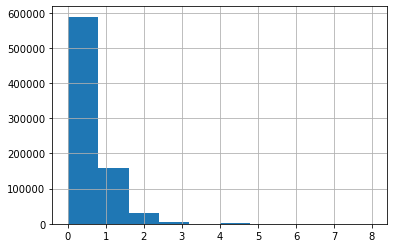

In [25]:
df_pairs["picks"].hist();

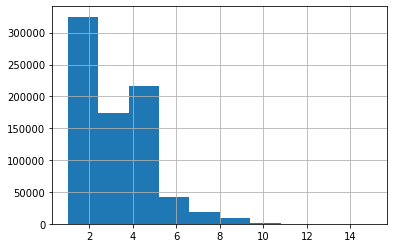

In [26]:
df_pairs["pick_opportunities"].hist();

In [27]:
print(f"Distrib for pairs that had AT LEAST MIN_PAIR_FREQ ({MIN_PAIR_FREQ})")
print(df_pairs.loc[df_pairs["pick_opportunities"]>=MIN_PAIR_FREQ].describe())
df_pairs.loc[df_pairs["pick_opportunities"]>=MIN_PAIR_FREQ]

Distrib for pairs that had AT LEAST MIN_PAIR_FREQ (4)
             picks  pick_opportunities   pick_ratio  round_skip_ratio  prior_white       ipw_wt
count  288246.0000         288246.0000  288246.0000          288246.0  288246.0000  288246.0000
mean        0.4963              4.9489       0.1002               0.0       0.1067       4.3101
std         0.7579              1.1612       0.1527               0.0       0.0514       5.2487
min         0.0000              4.0000       0.0000               0.0       0.0157       1.0159
25%         0.0000              4.0000       0.0000               0.0       0.0677       1.0815
50%         0.0000              5.0000       0.0000               0.0       0.0962       1.1494
75%         1.0000              6.0000       0.2000               0.0       0.1374       6.8285
max         8.0000             15.0000       1.0000               0.0       0.2929      63.7603


,white_card_text,black_card_text,picks,pick_opportunities,pick_ratio,round_skip_ratio,prior_white,ipw_wt
68,Existing.,"You're not going to believe this, but I'm you from the future! You've got to stop _____.",4,4,1.0,0.0,0.1414,7.0708
148,Balls.,"My anaconda don't want none unless you got _____, hun.",4,4,1.0,0.0,0.1828,5.4709
296,Oompa-Loompas.,We're here! We're _____! Get used to it!,4,4,1.0,0.0,0.1871,5.3452
496,Barely legal boys.,Get ready for the movie of the summer! One cop plays by the book. The other's only interested in one thing: _____.,5,5,1.0,0.0,0.1857,5.3855
607,Our dumb asshole president.,"IF you like _____, YOU MIGHT BE A REDNECK.",4,4,1.0,0.0,0.1828,5.4719
...,...,...,...,...,...,...,...,...
786545,"Freaky, pan-dimensional sex with a demigod.","Blessed are you, Lord our God, creator of the universe, who has granted us _____.",0,4,0.0,0.0,0.1552,1.1837
786547,"Freaky, pan-dimensional sex with a demigod.","But before I kill you, Mr. Bond, I must show you _____.",0,5,0.0,0.0,0.1552,1.1837
786551,"Freaky, pan-dimensional sex with a demigod.",A recent laboratory study shows that undergraduates have 50% less sex after being exposed to _____.,0,4,0.0,0.0,0.1552,1.1837
786552,Frantically writing equations on a chalkboard.,_____. It's a trap!,0,6,0.0,0.0,0.0321,1.0332


In [28]:
print("popular pairs / multiple times picked")
df_pop = df_pairs.loc[(df_pairs["pick_opportunities"]>=2) & (df_pairs["picks"]>1)].sort_values("picks",ascending=False)
print(df_pop.describe().round(2))
print(df_pop.shape[0])
print("nunique",df_pop.reset_index()[["black_card_text","white_card_text"]].nunique())
df_pop.reset_index()[["black_card_text","white_card_text","picks"]].head(12)

popular pairs / multiple times picked
          picks  pick_opportunities  pick_ratio  round_skip_ratio  prior_white    ipw_wt
count  38602.00            38602.00    38602.00           38602.0     38602.00  38602.00
mean       2.22                4.74        0.52               0.0         0.15      8.12
std        0.51                1.67        0.20               0.0         0.06      4.11
min        2.00                2.00        0.13               0.0         0.01      3.41
25%        2.00                4.00        0.40               0.0         0.10      5.37
50%        2.00                5.00        0.50               0.0         0.14      6.98
75%        2.00                6.00        0.67               0.0         0.19      9.63
max        8.00               15.00        1.00               0.0         0.29    197.11
38602
nunique black_card_text     439
white_card_text    1952
dtype: int64


,black_card_text,white_card_text,picks
0,"Run, run, as fast as you can! You can't catch me, I'm _____!",COVID-19.,8
1,"Hey, honey. For the bedroom, were you thinking ""Robin's Egg Blue"" or ""_____ Pink?""",My first period.,8
2,"Hey, honey. For the bedroom, were you thinking ""Robin's Egg Blue"" or ""_____ Pink?""",Chunks of dead hitchhiker.,7
3,Click Here for _____!!!,"Bill Clinton, naked on a bearskin rug with a saxophone.",7
4,Life for American Indians was forever changed when the White Man introduced them to _____.,The right amount of cocaine.,6
5,"Dear Abby, I'm having some trouble with _____ and would like your advice.",Fucking a corpse back to life.,6
6,What's there a ton of in heaven?,"Sluts, whores, and bitches.",6
7,"As the mom of five rambunctious boys, I'm no stranger to _____.",Boring vaginal sex.,6
8,"But before I kill you, Mr. Bond, I must show you _____.",A finger up the butt.,6
9,What's secretly a Russian plot to destabilize the West?,This horrible thing called Twitter.,6


In [29]:
# df_pop.loc[df_pop["picks"]>2].reset_index().sort_values(["white_card_text","picks"],ascending=False)[["white_card_text","black_card_text"]].head(15).values
df_pop.loc[df_pop["picks"]>2].reset_index().sort_values(["white_card_text","picks"],ascending=False)["black_card_text"].head(15).values

array(['FW: re: FBI WARNING!!! VIOLENT GANGS USING _____ TO RECRUIT CHILDREN!',
       'Computer! Display _____ on screen. Enhance.',
       "Seriously guys, there's nothing funny about _____.",
       "Hi MTV! My name is Kendra, I live in Malibu, I'm into _____, and I love to have a good time.",
       'The secret to a lasting marriage is communication, communication, and _____.',
       "After four platinum albums and three Grammys, it's time to get back to my roots, to what inspired me to make music in the first place: _____.",
       'The blind date was going horribly until we discovered our shared interest in _____.',
       'Having tired of poetry and music, the immortal elves now fill their days with _____.',
       'Why my mustache smell so bad?',
       'What will end racism once and for all?',
       '_____: kid-tested, mother-approved.',
       'IF you like _____, YOU MIGHT BE A REDNECK.',
       'What totally destroyed my asshole?',
       'Why my mustache smell so bad?',
 

In [30]:
df_pairs.loc[df_pairs["pick_opportunities"]>=4].head()

,white_card_text,black_card_text,picks,pick_opportunities,pick_ratio,round_skip_ratio,prior_white,ipw_wt
68,Existing.,"You're not going to believe this, but I'm you from the future! You've got to stop _____.",4,4,1.0,0.0,0.1414,7.0708
148,Balls.,"My anaconda don't want none unless you got _____, hun.",4,4,1.0,0.0,0.1828,5.4709
296,Oompa-Loompas.,We're here! We're _____! Get used to it!,4,4,1.0,0.0,0.1871,5.3452
496,Barely legal boys.,Get ready for the movie of the summer! One cop plays by the book. The other's only interested in one thing: _____.,5,5,1.0,0.0,0.1857,5.3855
607,Our dumb asshole president.,"IF you like _____, YOU MIGHT BE A REDNECK.",4,4,1.0,0.0,0.1828,5.4719


In [31]:
df_pairs[["pick_opportunities","picks","pick_ratio"]].corr() # ,"picks_sum"

,pick_opportunities,picks,pick_ratio
pick_opportunities,1.0000,0.2846,0.0027
picks,0.2846,1.0000,0.8092
pick_ratio,0.0027,0.8092,1.0000


In [32]:
print(" >= 2",df_pairs.loc[df_pairs["pick_opportunities"]>=2].shape[0])
print(" >= 5",df_pairs.loc[df_pairs["pick_opportunities"]>=5].shape[0])
print(" >= 7",df_pairs.loc[df_pairs["pick_opportunities"]>=7].shape[0])
df_pairs["pick_opportunities"].value_counts().sort_index()

 >= 2 636457
 >= 5 155233
 >= 7 29781


1     150112
2     174899
3     173312
4     133013
5      82712
6      42740
7      18933
8       7232
9       2525
10       765
11       242
12        61
13        18
14         3
15         2
Name: pick_opportunities, dtype: int64

In [33]:
print(df_pairs["picks"].value_counts().sort_index())
100*df_pairs["picks"].value_counts(normalize=True).sort_index()

0    589032
1    158935
2     31566
3      5805
4      1031
5       176
6        20
7         2
8         2
Name: picks, dtype: int64


0    74.8862
1    20.2061
2     4.0131
3     0.7380
4     0.1311
5     0.0224
6     0.0025
7     0.0003
8     0.0003
Name: picks, dtype: float64

# Initial classification target:  Was a card combination ever picked? 
* Ideally we'd use a higher threshhold, e.g. at least 3-5 instances, but that leaves us with relatively little data. 
* binary target: was it ever picked, for a given combo. (i.e clip at 1, 0/1)

In [34]:
df_pairs["pick_opportunities"].describe()

count    786569.0000
mean          3.1102
std           1.6911
min           1.0000
25%           2.0000
50%           3.0000
75%           4.0000
max          15.0000
Name: pick_opportunities, dtype: float64

* We can set the target to be picked at leat once, or picked more than a random uniform average (~10.6%)
    * We can use the background uniform distribution, instead of the distrib for "popularly picked". 

In [35]:
df_pairs["pick_ratio"] = df_pairs["picks"].div(df_pairs["pick_opportunities"])
# print("global pick_ratio\n",df_pairs["pick_ratio"].describe())
print(df_pairs.loc[df_pairs["pick_opportunities"]>=MIN_PAIR_FREQ]["pick_ratio"].describe())

MEAN_PICK_RATIO = df_pairs.loc[df_pairs["pick_opportunities"]>=MIN_PAIR_FREQ]["pick_ratio"].mean() + 0.005 # .median() #

count    288246.0000
mean          0.1002
std           0.1527
min           0.0000
25%           0.0000
50%           0.0000
75%           0.2000
max           1.0000
Name: pick_ratio, dtype: float64


In [36]:
print(df_pairs.shape[0],f"# rows before filter of MIN_PAIR_FREQ ({MIN_PAIR_FREQ})")
df_data = df_pairs.loc[df_pairs["pick_opportunities"]>=MIN_PAIR_FREQ][["white_card_text","black_card_text","picks"
                                                                       ,"pick_opportunities","ipw_wt"]].copy()
df_data["pick_ratio"] = df_data["picks"].div(df_data["pick_opportunities"]) ## target % , instead of boolean
df_data["picks_sum"] = df_data["picks"] # copy of raw count of times picked as funny
## We can set the target to be picked at leat once, or picked more than a random uniform average (~10.6%)
df_data["picks"] = df_data["picks"].clip(upper=1) # Bool target 
print(df_data["picks"].mean(), "boolean target mean")

# ## OPTIONAL: change to "picked more than most" target
# df_data["picks"] = (df_data["pick_ratio"] > MEAN_PICK_RATIO).astype(int)

print(df_data.shape[0],"# rows after filter")
print("pick_ratio\n",df_data["pick_ratio"].describe())
print(df_data["picks"].mean(), "target mean")

786569 # rows before filter of MIN_PAIR_FREQ (4)
0.3677414430729308 boolean target mean
288246 # rows after filter
pick_ratio
 count    288246.0000
mean          0.1002
std           0.1527
min           0.0000
25%           0.0000
50%           0.0000
75%           0.2000
max           1.0000
Name: pick_ratio, dtype: float64
0.3677414430729308 target mean


In [37]:
### add mean picks ratio, for this subset of data (regression). May not represent just white card data??? 
## for now, fit on just white cards, instead of black, white  (For black, we could just use mean_skipped as prior and multiply)
cat_encoder.fit(X=df_data["white_card_text"],y=df_data["pick_ratio"])

df_data["prior_white_paired_reg_ratio"] = cat_encoder.transform(df_data["white_card_text"]) ## catboost encoder - doesn't have min 0 (for those with 0 cases)
df_data.drop_duplicates(["white_card_text"])[["prior_white_paired_reg_ratio","pick_ratio"]].describe(percentiles=[])

,prior_white_paired_reg_ratio,pick_ratio
count,1964.0000,1964.0000
mean,0.0998,0.6306
std,0.0502,0.1692
min,0.0118,0.0000
50%,0.0895,0.6000
max,0.2929,1.0000


In [38]:
## add total count of black, white cards
df_data = df_data.merge(df_black[["pick_opportunities","round_skip_ratio"]].rename(columns={"pick_opportunities":"black_counts",
                                                                                 "round_skip_ratio":"black_round_skip_ratio"}),  on="black_card_text")

df_data = df_data.merge(df_white[["pick_opportunities","picks","pick_ratio"]].rename({"pick_opportunities":"white_counts",
                                                                       "picks":"white_picks","pick_ratio":"prior_white_pick_ratio"},axis=1),on="white_card_text")

# df_data.reset_index(inplace=True)
print(df_data.shape)


(288246, 13)


In [39]:
df_data["pick_ratio-sub-prior_white_pick_ratio"] = df_data["pick_ratio"].sub(df_data["prior_white_pick_ratio"])
df_data["pick_ratio-div-prior_white_pick_ratio"] = df_data["pick_ratio"].div(df_data["prior_white_pick_ratio"])

df_data["pick_ratio-sub-prior_white_paired_reg_ratio"] = df_data["pick_ratio"].sub(df_data["prior_white_paired_reg_ratio"])
df_data["pick_ratio-div-prior_white_paired_reg_ratio"] = df_data["pick_ratio"].div(df_data["prior_white_paired_reg_ratio"])

In [40]:
df_data.sort_values(["pick_ratio"],ascending=False)

,white_card_text,black_card_text,picks,pick_opportunities,ipw_wt,pick_ratio,picks_sum,prior_white_paired_reg_ratio,black_counts,black_round_skip_ratio,white_counts,white_picks,prior_white_pick_ratio,pick_ratio-sub-prior_white_pick_ratio,pick_ratio-div-prior_white_pick_ratio,pick_ratio-sub-prior_white_paired_reg_ratio,pick_ratio-div-prior_white_paired_reg_ratio
0,Existing.,"You're not going to believe this, but I'm you from the future! You've got to stop _____.",1,4,7.0708,1.0,4,0.1429,6520,0.0414,1472,209,0.1420,0.8580,7.0431,0.8571,6.9992
27442,The economy.,Mom's to-do list: • Buy groceries • Clean up _____ • Soccer practice,1,4,11.5544,1.0,4,0.0732,6280,0.0748,1481,138,0.0932,0.9068,10.7319,0.9268,13.6621
100146,Mexicans and Muslims.,"This app is basically Tinder, but for _____.",1,4,6.2173,1.0,4,0.1490,6310,0.0523,1496,245,0.1638,0.8362,6.1061,0.8510,6.7131
100005,Meth.,"This month's Cosmo: ""Spice up your sex life by bringing _____ into the bedroom.""",1,4,4.0331,1.0,4,0.2430,6190,0.0404,1550,374,0.2413,0.7587,4.1444,0.7570,4.1148
100004,Meth.,"To prepare for his upcoming role, Daniel Day-Lewis immersed himself in the world of _____.",1,4,4.0331,1.0,4,0.2430,6450,0.0527,1550,374,0.2413,0.7587,4.1444,0.7570,4.1148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120288,A fart so powerful that it wakes the giants from their thousand-year slumber.,"It's late at night. You're in bed with your lover, Patrick Stewart. He leans over with a twinkle in his eye and asks ""How about _____?""",0,4,1.1598,0.0,0,0.1465,5890,0.0628,1556,219,0.1407,-0.1407,0.0000,-0.1465,0.0000
120290,A fart so powerful that it wakes the giants from their thousand-year slumber.,50% of all marriages end in _____.,0,5,1.1598,0.0,0,0.1465,6380,0.0251,1556,219,0.1407,-0.1407,0.0000,-0.1465,0.0000
120291,A fart so powerful that it wakes the giants from their thousand-year slumber.,Having the worst day EVER. #_____,0,5,1.1598,0.0,0,0.1465,6650,0.0496,1556,219,0.1407,-0.1407,0.0000,-0.1465,0.0000
120292,A fart so powerful that it wakes the giants from their thousand-year slumber.,"Dance like there's nobody watching, love like you'll never be hurt, and live like you're _____.",0,6,1.1598,0.0,0,0.1465,6320,0.0396,1556,219,0.1407,-0.1407,0.0000,-0.1465,0.0000


## Save data

In [41]:
if SAVE_TRAIN_DATA:
#     df_data[["black_card_text","white_card_text","picks","pick_opportunities","picks_sum","ipw_wt","prior_white_pick_ratio"]].sample(frac=1).to_csv(f"cah_min{MIN_PAIR_FREQ}_v3.csv.gz",index=False,compression="gzip")
    df_data.drop(["black_counts"],axis=1,errors="ignore").sample(frac=1).to_csv(f"cah_min{MIN_PAIR_FREQ}_v4.csv.gz",index=False,compression="gzip")
#     df_data.sample(frac=1).to_csv(f"cah_min{MIN_PAIR_FREQ}_v3.csv.gz",index=False,compression="gzip")

## Sentence transformers models

In [42]:
df = df_data[["black_card_text","white_card_text","picks"]].sample(frac=1)#.values
df["picks"] = df["picks"].astype(float) ## needed for pytorch
df

,black_card_text,white_card_text,picks
222690,Lovin' you is easy 'cause you're _____.,Casually suggesting a threesome.,1.0
105489,Oh my god! _____ killed Kenny!,Destroying Dick Cheney's last horcrux.,1.0
207015,"Congratulations! You have been selected for our summer internship program. While we are unable to offer a salary, we can offer you _____.",Square dancing with other racists.,0.0
282045,"As reparations for slavery, all African Americans will receive _____.",Strong female characters.,1.0
98643,"In his newest and most difficult stunt, David Blaine must escape from _____.",Having a heart attack.,0.0
...,...,...,...
263801,You know who else liked _____? Hitler.,A magnificent chrome sphere that roams the streets evaporating criminals.,0.0
176082,It's the 21st century. A woman shouldn't have to apologize for _____.,Giving grandma crappy things she doesn't like.,0.0
196553,I'm going on a cleanse this week. Nothing but kale juice and _____.,Your mouth.,0.0
277187,"Coming to Broadway this season, _____: The Musical.",Fiery poops.,0.0


## Sentence transformers model(s)
* Sentence bert (NLI? semtantic similarity?) 
https://www.sbert.net/docs/training/overview.html
https://www.sbert.net/docs/quickstart.html  , https://github.com/UKPLab/sentence-transformers
* Load data from disk ? 

* list of pretrained sentencebert models: (All are >300 M! slow download) https://docs.google.com/spreadsheets/d/14QplCdTCDwEmTqrn1LH4yrbKvdogK4oQvYO1K1aPR5M/edit#gid=0

* `stsb-distilroberta-base-v2` - 305M sized model - semantic similarity
* `nli-distilroberta-base-v2` - NLI 
* `average_word_embeddings_glove.6B.300d`, `average_word_embeddings_glove.840B.300d` - glove/w2v embeddings

In [43]:
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses, evaluation
import torch
torch.cuda.is_available()
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
## https://stackoverflow.com/questions/50307707/convert-pandas-dataframe-to-pytorch-tensor
from transformers import AutoTokenizer, AutoModel
## example from : https://www.sbert.net/docs/training/overview.html
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses 


In [44]:
## pretrained weights - download vis program often fails, easier to download externally from ftp
# model = SentenceTransformer('stsb-distilroberta-base-v2') ## was distilbert-base-nli-mean-tokens

# model = SentenceTransformer('average_word_embeddings_glove.6B.300d') ## was distilbert-base-nli-mean-tokens

# model = SentenceTransformer("nli-distilroberta-base-v2",device="cuda")
model = SentenceTransformer("paraphrase-MiniLM-L6-v2") ## "paraphrase-MiniLM-L12-v2"

# model = SentenceTransformer("./stsb-distilroberta-base-v2",device="cuda")

# model = SentenceTransformer("./nli-mpnet-base-v2",device="cuda")

In [45]:
model.max_seq_length

128

In [46]:
# len(model.tokenize(["ad and "])["input_ids"])

In [47]:
model.get_sentence_embedding_dimension() # 768

384

#### redo above, but with real data


In [48]:
df

,black_card_text,white_card_text,picks
222690,Lovin' you is easy 'cause you're _____.,Casually suggesting a threesome.,1.0
105489,Oh my god! _____ killed Kenny!,Destroying Dick Cheney's last horcrux.,1.0
207015,"Congratulations! You have been selected for our summer internship program. While we are unable to offer a salary, we can offer you _____.",Square dancing with other racists.,0.0
282045,"As reparations for slavery, all African Americans will receive _____.",Strong female characters.,1.0
98643,"In his newest and most difficult stunt, David Blaine must escape from _____.",Having a heart attack.,0.0
...,...,...,...
263801,You know who else liked _____? Hitler.,A magnificent chrome sphere that roams the streets evaporating criminals.,0.0
176082,It's the 21st century. A woman shouldn't have to apologize for _____.,Giving grandma crappy things she doesn't like.,0.0
196553,I'm going on a cleanse this week. Nothing but kale juice and _____.,Your mouth.,0.0
277187,"Coming to Broadway this season, _____: The Musical.",Fiery poops.,0.0


In [49]:
num_epochs = 2
TEST_SIZE = df.shape[0]//8 #4500
print(TEST_SIZE)

36030


In [50]:
df.shape

(288246, 3)

In [51]:
df.drop_duplicates(['black_card_text', 'white_card_text']).shape[0]

288246

In [52]:
## is list correct? error otherwise? 
train_examples = list(df.iloc[TEST_SIZE:].apply(lambda row: InputExample(texts=[row["white_card_text"], row["black_card_text"]],
                                                                         label=row["picks"]),axis=1)) # picks
test_examples =  list(df.iloc[0:TEST_SIZE].apply(lambda row: InputExample(texts=[row["white_card_text"], row["black_card_text"]], 
                                                                          label=row["picks"]),axis=1)) # picks


In [53]:
# dev_eval = evaluation.BinaryClassificationEvaluator(sentences1=df.iloc[0:2500,0],
#     sentences2= df.iloc[0:2500,1],
#     labels=df.iloc[0:2500,2],show_progress_bar=True,batch_size=256)
dev_eval = evaluation.BinaryClassificationEvaluator(sentences1=list(df.iloc[0:TEST_SIZE,0].values),
    sentences2= list(df.iloc[0:TEST_SIZE,1].values),
    labels=list(df.iloc[0:TEST_SIZE,2].values),show_progress_bar=True,batch_size=256)

In [54]:
## https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/nli/training_nli.py 

## evaluator example 
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=256)


In [55]:
%%time
# train_loss = losses.CosineSimilarityLoss(model) # ORIG

# train_loss = losses.SoftmaxLoss(model,
#     sentence_embedding_dimension= model.get_sentence_embedding_dimension(),
#     num_labels= 2,
#     concatenation_sent_rep= True,
#     concatenation_sent_difference = True,
#     concatenation_sent_multiplication = True) # ALT - for classification https://www.sbert.net/docs/package_reference/losses.html#softmaxloss

train_loss = losses.CosineSimilarityLoss(model)
#Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], 
          epochs=num_epochs, 
#           warmup_steps=100, # 100
          warmup_steps = math.ceil(len(train_dataloader) * 0.05*3), #5% of train data for warm-up
          evaluator=dev_eval,
          use_amp=True,
          optimizer_params= {'lr': 3e-04}, # 2e-05
          output_path="./output",
          save_best_model = False,
         )

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1971 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1971 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1971 [00:00<?, ?it/s]

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 14min 46s


In [56]:
model.evaluate(dev_eval)

Batches:   0%|          | 0/10 [00:00<?, ?it/s]

0.5460244073549838

#### Evaluate model on original data, game by game.
* Note: should use proper test set , disjoint

In [95]:
# df = pd.read_parquet('cah_lab_data.parquet')
df_test = df_sample.loc[df_sample["black_card_pick_num"]==1].sort_values("fake_round_id")[["fake_round_id","black_card_text","white_card_text","won"]].copy()

df_test = df_test.head(4800)
df_test

,fake_round_id,black_card_text,white_card_text,won
20001,274529,"I'm Tony Robbins, and over the next sixty minutes, I'm going to teach you how to harness the power of _____!",Swooping.,False
20004,274529,"I'm Tony Robbins, and over the next sixty minutes, I'm going to teach you how to harness the power of _____!",The peaceful and nonthreatening rise of China.,False
20003,274529,"I'm Tony Robbins, and over the next sixty minutes, I'm going to teach you how to harness the power of _____!","My Uber driver, Pavel.",False
20002,274529,"I'm Tony Robbins, and over the next sixty minutes, I'm going to teach you how to harness the power of _____!",Child support payments.,False
0,274529,"I'm Tony Robbins, and over the next sixty minutes, I'm going to teach you how to harness the power of _____!",Teenage pregnancy.,True
...,...,...,...,...
799,275481,"Instead of coal, Santa now gives the bad children _____.",Clams.,True
23998,275481,"Instead of coal, Santa now gives the bad children _____.",Getting caught by the police and going to jail.,False
23996,275481,"Instead of coal, Santa now gives the bad children _____.",Fancy Feast.®,False
23995,275481,"Instead of coal, Santa now gives the bad children _____.",How strange it is to be anything at all.,False


* if using just black/white, could do this for unique cards - ~1000 x less compute...

In [99]:
%%time
## https://www.sbert.net/docs/usage/semantic_textual_similarity.html

sentences1 = df_test["black_card_text"].values
sentences2 = df_test["white_card_text"].values
embeddings1 = model.encode(sentences1,batch_size=256,normalize_embeddings=False, convert_to_tensor=True)

embeddings2 = model.encode(sentences2,batch_size=256,normalize_embeddings=False, convert_to_tensor=True)

Wall time: 1.88 s


In [100]:
scores = []
#Compute cosine-similarits
cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

#Output the pairs with their score
for i in range(len(sentences1)):
#     print("{} \t\t {} \t\t Score: {:.4f}".format(sentences1[i], sentences2[i], cosine_scores[i][i]))
    scores.append(float(cosine_scores[i][i]))
df_test["cos_scores"] = scores
df_test.sort_values(["fake_round_id","cos_scores"],inplace=True,ascending=True)
print("top1 accuracy:",df_test.groupby("fake_round_id").head(1)["won"].mean())

df_test.sort_values(["fake_round_id","cos_scores"],inplace=True,ascending=False)
print("top1 accuracy, reverse sort:",df_test.groupby("fake_round_id").head(1)["won"].mean())
df_test

top1 accuracy: 0.08125
top1 accuracy, reverse sort: 0.34125


,fake_round_id,black_card_text,white_card_text,won,cos_scores
23996,275481,"Instead of coal, Santa now gives the bad children _____.",Fancy Feast.®,False,0.5201
23997,275481,"Instead of coal, Santa now gives the bad children _____.",The power of the Dark Side.,False,0.4402
799,275481,"Instead of coal, Santa now gives the bad children _____.",Clams.,True,0.3842
23999,275481,"Instead of coal, Santa now gives the bad children _____.","Marsha P. Johnson, the trans woman of color who may have thrown the first brick at Stonewall.",False,0.2346
23995,275481,"Instead of coal, Santa now gives the bad children _____.",How strange it is to be anything at all.,False,0.0967
...,...,...,...,...,...
20002,274529,"I'm Tony Robbins, and over the next sixty minutes, I'm going to teach you how to harness the power of _____!",Child support payments.,False,0.4111
20003,274529,"I'm Tony Robbins, and over the next sixty minutes, I'm going to teach you how to harness the power of _____!","My Uber driver, Pavel.",False,0.3036
20000,274529,"I'm Tony Robbins, and over the next sixty minutes, I'm going to teach you how to harness the power of _____!",Schindler's List.,False,0.2734
20004,274529,"I'm Tony Robbins, and over the next sixty minutes, I'm going to teach you how to harness the power of _____!",The peaceful and nonthreatening rise of China.,False,0.1944


0.08125

#### Try  other model 
* https://www.sbert.net/docs/package_reference/evaluation.html

In [57]:
# del model

# torch.cuda.empty_cache()
# with torch.cuda.device('cuda:0'):
#     torch.cuda.empty_cache()

In [58]:
# model2 = SentenceTransformer("./nli-mpnet-base-v2",device="cuda")
# print(model2.get_sentence_embedding_dimension())

In [59]:
# %%time
# ### cuda memor allocation error? 
# train_loss = losses.SoftmaxLoss(model2,
#     sentence_embedding_dimension= model2.get_sentence_embedding_dimension(),
#     num_labels= 2,
#     concatenation_sent_rep= True,
#     concatenation_sent_difference = True,
#     concatenation_sent_multiplication = True) # ALT - for classification https://www.sbert.net/docs/package_reference/losses.html#softmaxloss

# #Tune the model
# model2.fit(train_objectives=[(train_dataloader, train_loss)], 
#           epochs=1, 
#           warmup_steps=100, # 100
#           evaluator=dev_eval,
#            save_best_model = False,
#           use_amp=True,
#           optimizer_params= {'lr': 1e-03}, # 2e-05
#           output_path="./output2"
#          )